In [1]:
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.linalg import solve
from scipy.spatial import Delaunay
from scipy import interpolate
import plotly.figure_factory as ff
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

# Translated libs
from meshlib import *
from rwglib import *
from pwslib import *

# Creating mesh

View RWG_IFA for more detailed simulation of this IFA antenna. In this work I will try to check PWS

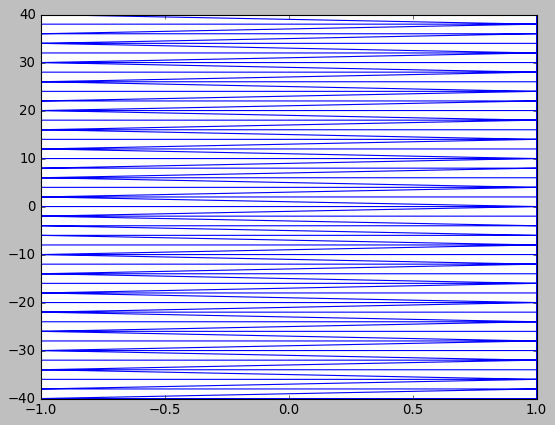

In [2]:
hull_bound_points = np.array([[1,-40],[-1,-40],[1,40],[-1,40]])
mesh_resolution = 2
tri = creatHull(hull_bound_points,mesh_resolution)
plt.triplot(tri.points[:,0], tri.points[:,1], tri.simplices)
plt.show()

Using function
$$to3D(tri2D,scaleX,scaleY,rotX,rotY,rotZ,dX,dY,dZ)$$

In [3]:
tri_final = to3D(tri,1/2000,1/800,0,0,0,0,0,0)

## Save to "p" and "t"

In [4]:
p = tri_final.points.T
t = np.ones((4,tri_final.simplices.shape[0]))
t[0:3,:] = tri_final.simplices.T + 1
t = t.astype(int)

# RWG1 Geometry calculations - all Chapters
Uses the structure mesh file, e.g. platefine.mat, as an input.

Creates the RWG edge element for every inner edge of the structure. The total number of elements is EdgesTotal.

Outputs the following arrays:

Edge first node number          

    Edge_(1,1:EdgesTotal)
   
Edge second node number  

    Edge_(2,1:EdgesTotal)
    
Plus triangle number  

    TrianglePlus(1:EdgesTotal)
   
Minus triangle number           

    TriangleMinus(1:EdgesTotal)
   
Edge length                     

    EdgeLength(1:EdgesTotal)
   
Edge element indicator          
    
    EdgeIndicator(1:EdgesTotal)

Also outputs areas and midpoints of separate triangles:

Triangle area                   

    Area(1:TrianglesTotal)
   
Triangle center                 

    Center(1:TrianglesTotal)      
   
This script may handle surfaces with T-junctions including monopoles over various metal surfaces and certain metal meshes

Copyright 2002 AEMM. Revision 2002/03/09 Chapter 2


Plot the mesh

In [5]:
x_,y_,z_ = p
fig_scale = max(max(x_)-min(x_),max(y_)-min(y_),max(z_)-min(z_))
x_scale,y_scale,z_scale=(max(x_)-min(x_))/fig_scale,(max(y_)-min(y_))/fig_scale,(max(z_)-min(z_))/fig_scale
fig1 = ff.create_trisurf(x=x_, y=y_, z=z_,
                         simplices=(t[0:3,:].T-1),
                         color_func=[i for i in range(len(t.T))],
                         show_colorbar=False,
                         title="Antenna mesh", aspectratio=dict(x=x_scale, y=y_scale, z=1))
fig1.show()

In [6]:
ANT_mesh1 = RWGmesh(p,t)

Total number of triangles is  80
Total number of edges is  79


This block is only meaningful for T junctions. It leaves only two edge elements at a junction

# RWG2: Geometry calculations - all Chapters
Uses the mesh file from RWG1, mesh1.mat, as an input.

Creates the following parameters of the RWG edge elements: 

Position vector rho_c_plus from the free vertex of the "plus" triangle to its center

                                   RHO_Plus(1:3,1:EdgesTotal)
                                   
Position vector rho_c_minus from the center of the "minus" triangle to its free vertex 

                                   RHO_Minus(1:3,1:EdgesTotal)

In addition to these parameters creates the following arrays for nine subtriangles (barycentric subdivision):

Midpoints of nine subtriangles

                                   Center_(1:3,1:9,1:TrianglesTotal)  
                                   
Position vectors rho_c_plus from the free vertex of the "plus" triangle to nine subtriangle midpoints

                                   RHO__Plus(1:3,1:9,1:EdgesTotal)
                                   
Position vectors rho_c_minus from nine subtriangle midpoints to the free vertex of the "minus" triangle

                                   RHO__Minus(1:3,1:9,1:EdgesTotal)

See Rao, Wilton, Glisson, IEEE Trans. Antennas and Propagation, vol. AP-30, No 3, pp. 409-418, 1982.

Copyright 2002 AEMM. Revision 2002/03/05 
Chapter 2

In [7]:
ANT_mesh2 = RWGmesh2(ANT_mesh1,t,p)

# Surface current - Radiated/scattered field over a large sphere

Uses the mesh file from RWG2, mesh2.mat, and the file containing surface current coefficients, current.mat, from RWG4 as inputs.

Uses the structure sphere.mat/sphere1.mat to display radiation intensity distribution over the sphere surface. 

The sphere doesn't intersect the radiating object.

The following parameters need to be specified:
        
        Sphere radius (m)

Copyright 2002 AEMM. Revision 2002/03/11 
Chapter 3

## Calculate impedance

Related to antenna feeding position

In [8]:
FeedPoint=[[0],[0],[0]]

In [9]:
f = 1500e6
epsilon_    = 8.854e-012
mu_         = 1.257e-006
c_=1/np.sqrt(epsilon_*mu_)
eta_=np.sqrt(mu_/epsilon_)

In [10]:
mat_fname_sphere = pjoin('mesh', 'sphere.mat')
print(mat_fname_sphere)
mat_contents_sphere = sio.loadmat(mat_fname_sphere)
p_sphere = mat_contents_sphere['p']
t_sphere = mat_contents_sphere['t']
p_sphere=100*p_sphere
K=1j*(2*np.pi*f/c_)

mesh\sphere.mat


In [11]:
NumPoints = 100
R = 1000 # meter - distance to the antenna

In [12]:
Z, I, Impedance, FeedPower = calculateImpedance(f,c_,mu_,epsilon_,
                                                           p,ANT_mesh1,ANT_mesh2,FeedPoint)
SCurrent = currentDistribution(t,ANT_mesh1,ANT_mesh2,I)
Jmax = max(SCurrent)
CurrentNorm = SCurrent/max(SCurrent)
fig2 = ff.create_trisurf(x=x_, y=y_, z=z_,
                         simplices=(t[0:3,:].T-1),
                         color_func=list(CurrentNorm),
                         show_colorbar=True,
                         title="Antenna mesh - Normalized current distribution", aspectratio=dict(x=x_scale, y=y_scale, z=1))
fig2.show()

Current vector's size (80,)


In [13]:
ANT_moment = RWGmoment(ANT_mesh1,I)
U, TotalPower = radiating3DPower(t_sphere,p_sphere,ANT_moment,K,eta_)
GainLogarithmic = 10*np.log10(4*np.pi*max(U)/TotalPower)
U_norm = 10*np.log10(U/np.linalg.norm(U))

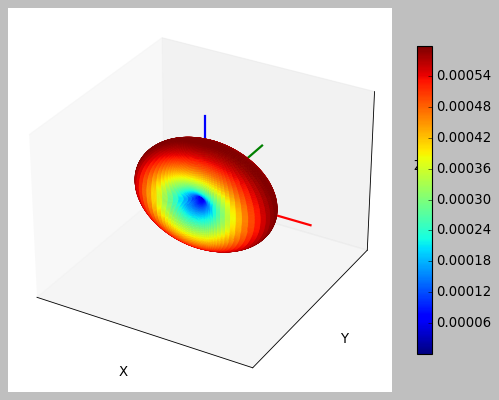

In [14]:
theta_ = (np.arange(NumPoints)/(NumPoints-1))*np.pi
phi_ = (-1/2 + np.arange(NumPoints)/(NumPoints-1))*np.pi*2
Theta, Phi = np.meshgrid(theta_,phi_)
#Field calculation 
FF_3D = np.zeros(Theta.shape)
for i in range(NumPoints):
    ObservationPointList = [np.array([R*np.sin(theta__)*np.cos(phi_[i]), R*np.sin(theta__)*np.sin(phi_[i]), R*np.cos(theta__)]) for theta__ in theta_]
    FF_3D[i,:], W_efield3 = radiating2DFields(ObservationPointList,ANT_moment,K,eta_)
        
Pattern3D(Theta, Phi, FF_3D)

In [15]:
Rad = 10*np.log10(4*np.pi*FF_3D/TotalPower)
print("Max directivity of the antenna is",np.max(Rad),"dBi")

Max directivity of the antenna is 2.150662674925001 dBi


# Calculate E-field and do some PWS stuffs

Calculate E-field at 20cm, propagate it at 50cm and compare the reconstructed field with the calculated (simulated) field.

### E-field @20mm

In [16]:
x_range = [-1,1]
y_range = x_range
distance = 0.02
Npoints = 201
x_ = np.linspace(x_range[0], x_range[1],Npoints)
y_ = np.linspace(y_range[0], y_range[1],Npoints)
x, y = np.meshgrid(x_, y_)
z = distance

#Field calculation 
E_field = np.zeros([Npoints, Npoints, 3],dtype = 'complex_')
H_field = np.zeros([Npoints, Npoints, 3],dtype = 'complex_')
for i in range(Npoints):
    for j in range(Npoints):
        ObservationPoint = np.array([x[i,j], y[i,j], z])
        U_field, W_efield, Poynting, E_field[i,j,:], H_field[i,j,:] = radiatingFields_atObservationPoint(ObservationPoint,ANT_moment,K,eta_)
E_field.shape

EField_20mm_org = field(E_field,x,y,z,Npoints,2*np.pi*f/c_,2*np.pi*f,epsilon_,1)
HField_20mm_org = field(H_field,x,y,z,Npoints,2*np.pi*f/c_,2*np.pi*f,epsilon_,1)

Originally, the E-field at 20mm

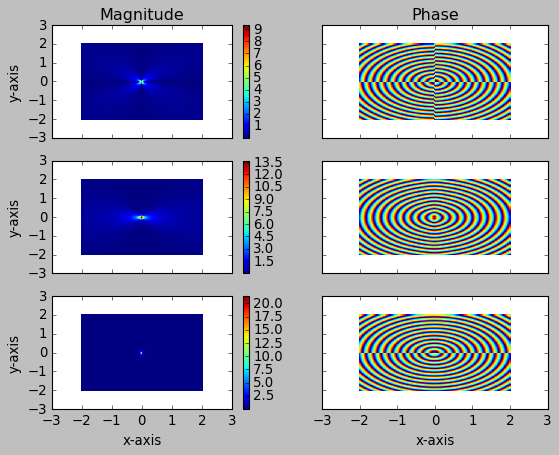

In [17]:
displayField(EField_20mm_org)

and the H-field at the same distace

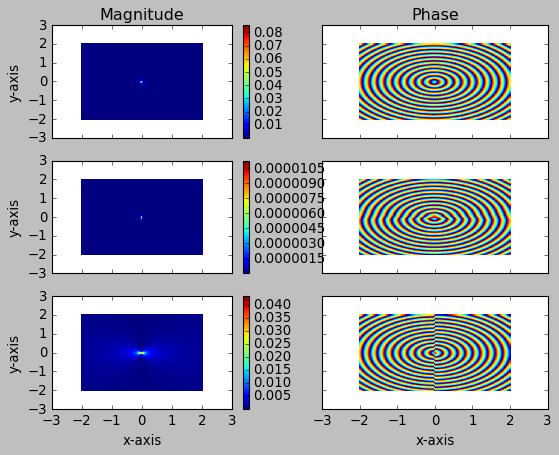

In [18]:
displayField(HField_20mm_org)

Imaging we have a dual-polarization probe system allows scanning the orthogonal components (X) and (Y) to the propagation direction of the E-field at 20mm. We need to reconstruct the full (3 components) E-field and H-field at 50mm. 

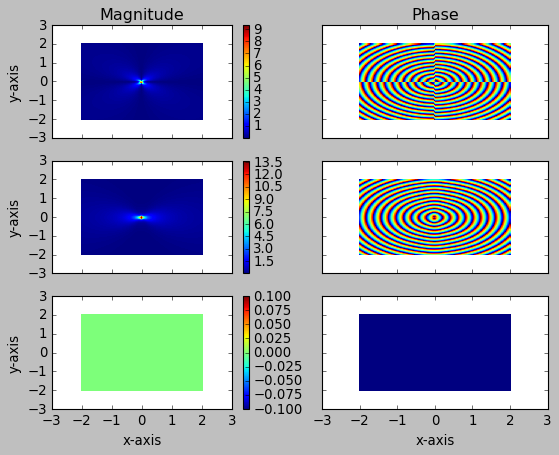

In [19]:
EField_20mm = deepcopy(EField_20mm_org)
EField_20mm.DZ = np.zeros(EField_20mm.DX.shape,dtype = 'complex_')
EField_20mm.D[:,:,2] = 0
displayField(EField_20mm)

**First step**: Reconstruct the Z component of the E-field at 20mm by Gauss's law:

$$sE_x.k_x + sE_y.k_y + sE_z.k_z = 0$$

Let's first prepare the spectral elements.

In [20]:
Nspec = Npoints
k0 = 2*np.pi*f/c_
dx = (x_range[1] - x_range[0])/(Npoints - 1) #1.25e-3
dy = (y_range[1] - y_range[0])/(Npoints - 1)
kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Npoints, d=dx))
ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Npoints, d=dy))
KX,KY = np.meshgrid(kx,ky)
KZ = np.conj(np.sqrt((k0**2-KX**2-KY**2)*(1+0j)))

Transform the spatial E-field to spectral one and reconstruct the missed component Z.

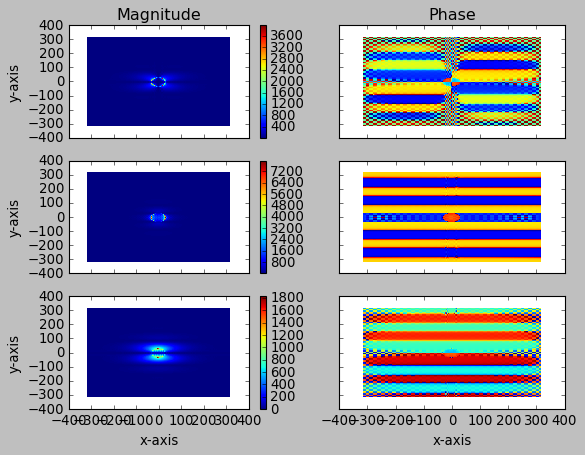

In [21]:
lambda_recz=np.abs(k0)*1e-4 # avoid dividing by 0
sEField_20mm = deepcopy(EField_20mm)
sEField_20mm.X = KX
sEField_20mm.Y = KY
sEField_20mm.Z = KZ
sEField_20mm.DX = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EField_20mm.DX)))
sEField_20mm.DY = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EField_20mm.DY)))
sEField_20mm.DZ = -(sEField_20mm.DX*KX + sEField_20mm.DY*KY)*(np.conj(KZ)/(lambda_recz**2+np.abs(KZ)**2))
sEField_20mm.D = np.swapaxes(np.stack([sEField_20mm.DX, sEField_20mm.DY, sEField_20mm.DZ],axis=1),1,2)

displayField(sEField_20mm)

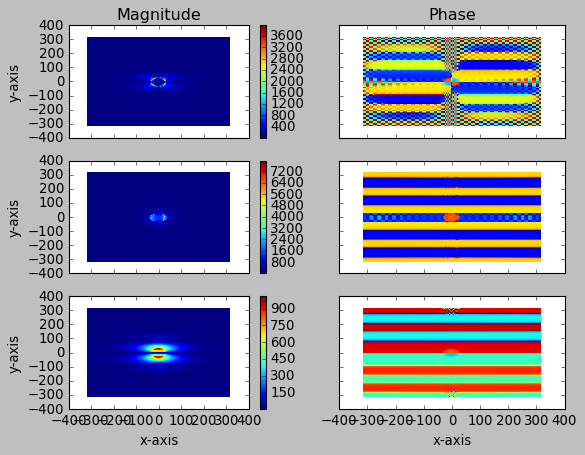

In [23]:
lambda_recz=np.abs(k0)*1e-4 # avoid dividing by 0
sEField_20mm_org = deepcopy(EField_20mm)
sEField_20mm_org.X = KX
sEField_20mm_org.Y = KY
sEField_20mm_org.Z = KZ
sEField_20mm_org.DX = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EField_20mm.DX)))
sEField_20mm_org.DY = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EField_20mm.DY)))
sEField_20mm_org.DZ = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EField_20mm_org.DZ)))
sEField_20mm_org.D = np.swapaxes(np.stack([sEField_20mm_org.DX, sEField_20mm_org.DY, sEField_20mm_org.DZ],axis=1),1,2)

displayField(sEField_20mm_org)

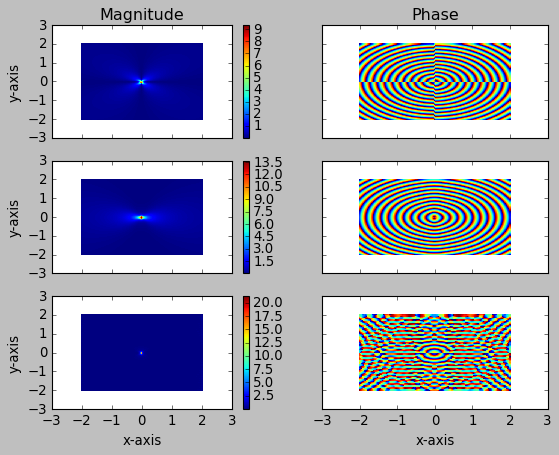

In [24]:
EField_20mm.DZ = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sEField_20mm.DZ)))
displayField(EField_20mm)

**Second step**: Reconstruc the H-field at 20mm by Maxwell–Faraday equation:

$$\bigtriangledown\times sE = j\omega\mu_0 .sH$$

or more detailed:

$$(sE_z.k_y - sE_y.k_z).\overrightarrow{e_x} + (sE_x.k_z - sE_z.k_x).\overrightarrow{e_y} + (sE_y.k_x - sE_x.k_y).\overrightarrow{e_z} = j\omega\mu_0 (sH_x.\overrightarrow{e_x} + sH_y.\overrightarrow{e_y} + sH_z.\overrightarrow{e_z})$$

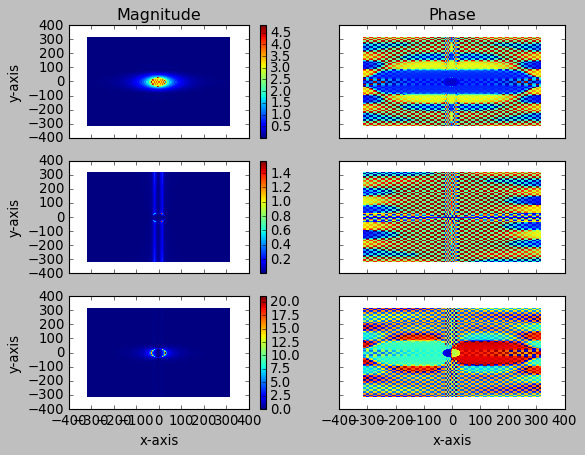

In [25]:
sHField_20mm = deepcopy(sEField_20mm)
sHField_20mm.X = KX
sHField_20mm.Y = KY
sHField_20mm.Z = KZ
sHField_20mm.DX = (sEField_20mm.DZ*KY - sEField_20mm.DY*KZ)/(1j*2*np.pi*f*mu_)
sHField_20mm.DY = (sEField_20mm.DX*KZ - sEField_20mm.DZ*KX)/(1j*2*np.pi*f*mu_)
sHField_20mm.DZ = (sEField_20mm.DY*KX - sEField_20mm.DX*KY)/(1j*2*np.pi*f*mu_)
sHField_20mm.D = np.swapaxes(np.stack([sHField_20mm.DX, sHField_20mm.DY, sHField_20mm.DZ],axis=1),1,2)

displayField(sHField_20mm)

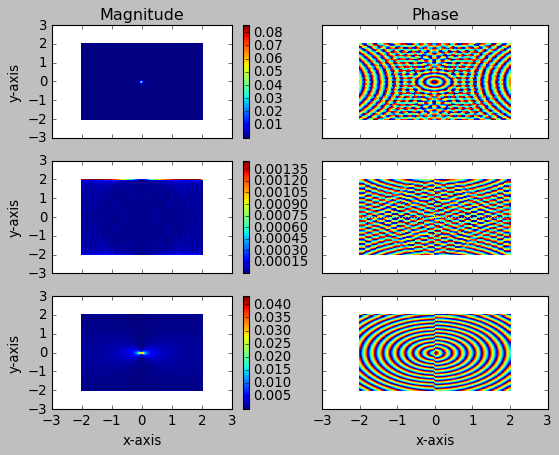

In [26]:
HField_20mm = deepcopy(EField_20mm)
HField_20mm.X = EField_20mm.X
HField_20mm.Y = EField_20mm.Y
HField_20mm.Z = EField_20mm.Z
HField_20mm.DX = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sHField_20mm.DX)))
HField_20mm.DY = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sHField_20mm.DY)))
HField_20mm.DZ = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sHField_20mm.DZ)))
HField_20mm.D = np.swapaxes(np.stack([sHField_20mm.DX, sHField_20mm.DY, sHField_20mm.DZ],axis=1),1,2)

displayField(HField_20mm)

**Third step**: Propagate both E-field and H-field to 50mm by Plane Wave Expansion:

$$sE_{x/y/z-50mm} = sE_{x/y/z-20mm}.e^{-j(0.05-0.02)kz}$$

and

$$sH_{x/y/z-50mm} = sH_{x/y/z-20mm}.e^{-j(0.05-0.02)kz}$$

Let's first prepare the propagator $e^{-j(0.05-0.02)kz}$ in the equation:

In [27]:
propagator = np.fft.ifftshift(np.exp(-1j*(0.05-0.02)*KZ))

Then, propagate both fields.

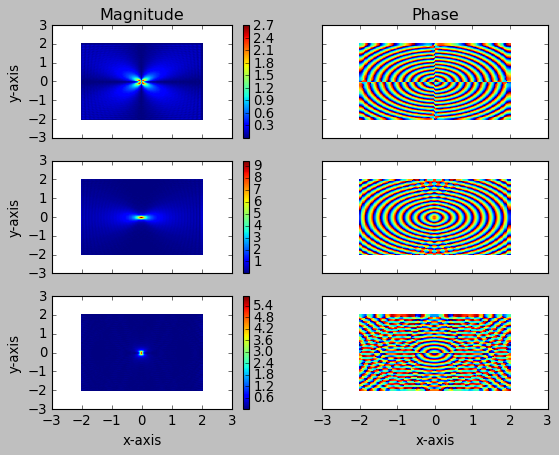

In [28]:
EField_50mm_rec = deepcopy(EField_20mm)
EField_50mm_rec.Z = 0.05
EField_50mm_rec.DX = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(EField_20mm.DX)))
EField_50mm_rec.DY = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(EField_20mm.DY)))
EField_50mm_rec.DZ = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(EField_20mm.DZ)))
EField_50mm_rec.D = np.swapaxes(np.stack([EField_50mm_rec.DX, EField_50mm_rec.DY, EField_50mm_rec.DZ],axis=1),1,2)
displayField(EField_50mm_rec)

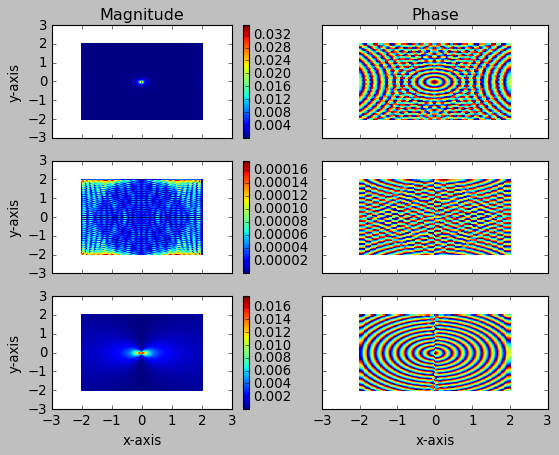

In [29]:
HField_50mm_rec = deepcopy(HField_20mm)
HField_50mm_rec.Z = 0.05
HField_50mm_rec.DX = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(HField_20mm.DX)))
HField_50mm_rec.DY = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(HField_20mm.DY)))
HField_50mm_rec.DZ = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(HField_20mm.DZ)))
HField_50mm_rec.D = np.swapaxes(np.stack([HField_50mm_rec.DX, HField_50mm_rec.DY, HField_50mm_rec.DZ],axis=1),1,2)
displayField(HField_50mm_rec)

## E-field @50mm

In [30]:
distance = 0.05
z = distance

#Field calculation 
E_field = np.zeros([Npoints, Npoints, 3],dtype = 'complex_')
H_field = np.zeros([Npoints, Npoints, 3],dtype = 'complex_')
for i in range(Npoints):
    for j in range(Npoints):
        ObservationPoint = np.array([x[i,j], y[i,j], z])
        U_field, W_efield, Poynting, E_field[i,j,:], H_field[i,j,:] = radiatingFields_atObservationPoint(ObservationPoint,ANT_moment,K,eta_)
E_field.shape

EField_50mm_org = field(E_field,x,y,z,Npoints,2*np.pi*f/c_,2*np.pi*f,epsilon_,1)
HField_50mm_org = field(H_field,x,y,z,Npoints,2*np.pi*f/c_,2*np.pi*f,epsilon_,1)

Originally, the E-field at 50mm

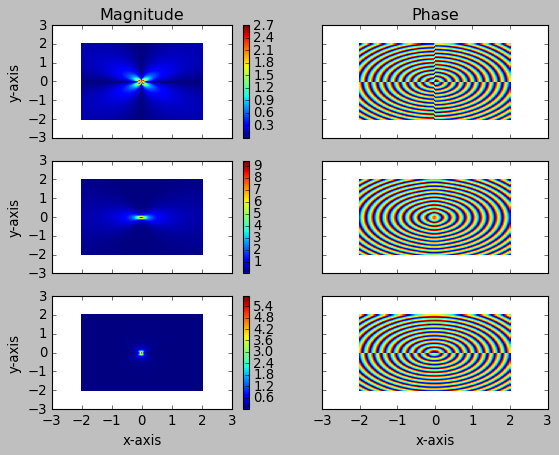

In [31]:
displayField(EField_50mm_org)

and the H-field at 50mm

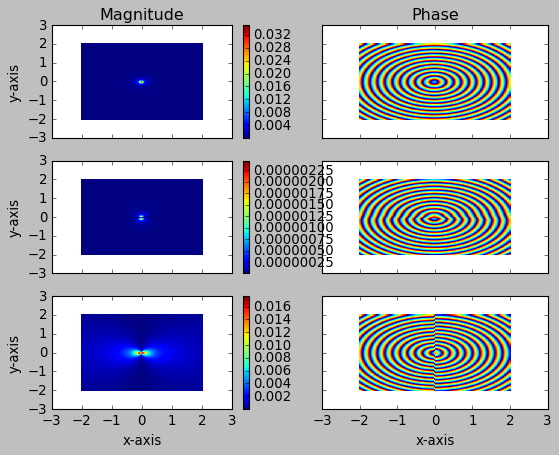

In [32]:
displayField(HField_50mm_org)

Both figures look alike ain't they!!! I will say that the PWS has successfully reconstruct the field in the direction of propagation!!

### Retro-propagation is still a huge problem!!!

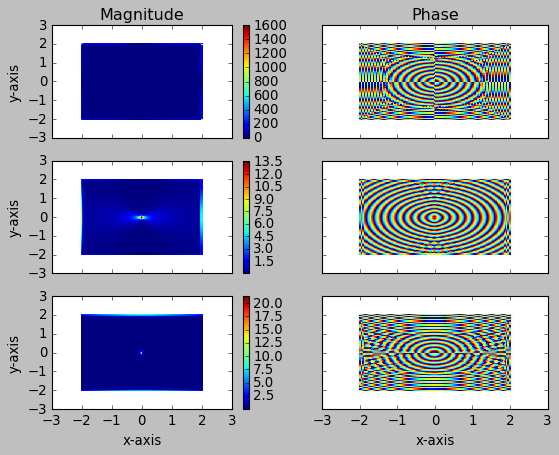

In [33]:
EField_20mm_rec = propagation(EField_50mm_org,0.02,EField_20mm.N,2*np.pi*f/c_)
displayField(EField_20mm_rec)

## Draft

In [46]:
 from scipy import signal

In [49]:
window1d = signal.tukey(51)
window2d = np.sqrt(np.outer(window1d,window1d))
window2d[20:30,20:30]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [34]:
k0 = 2*np.pi*f/c_
t = 19
theta_ = (np.arange(t)/(t-1))*np.pi
phi_ = (-1/2 + np.arange(t)/(t-1))*np.pi*2
Theta, Phi = np.meshgrid(theta_,phi_)
kx_spherical = np.zeros((t,t))
ky_spherical = np.zeros((t,t))
kz_spherical = np.zeros((t,t))

for m in range(t):
    for n in range(t):
        kx_spherical[m,n] = k0*np.sin(theta_[m])*np.cos(phi_[n])
        ky_spherical[m,n] = k0*np.sin(theta_[m])*np.sin(phi_[n])
        kz_spherical[m,n] = np.cos(theta_[m])
kx_spherical.shape

(19, 19)

In [35]:
Theta[0]

array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
       1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
       2.61799388, 2.7925268 , 2.96705973, 3.14159265])

In [36]:
Phi[0]

array([-3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265])

In [37]:
kx_spherical[0]

array([-0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0., -0., -0., -0.])

In [38]:
from scipy import interpolate

In [39]:
sE_FFX_fct_real = interpolate.interp2d(sEField_20mm.X[0,:], sEField_20mm.Y[:,0], np.real(sEField_20mm.DX), kind='cubic')
sE_FFX_fct_imag = interpolate.interp2d(sEField_20mm.X[0,:], sEField_20mm.Y[:,0], np.imag(sEField_20mm.DX), kind='cubic')

sE_FFY_fct_real = interpolate.interp2d(sEField_20mm.X[0,:], sEField_20mm.Y[:,0], np.real(sEField_20mm.DY), kind='cubic')
sE_FFY_fct_imag = interpolate.interp2d(sEField_20mm.X[0,:], sEField_20mm.Y[:,0], np.imag(sEField_20mm.DY), kind='cubic')

sE_FFZ_fct_real = interpolate.interp2d(sEField_20mm.X[0,:], sEField_20mm.Y[:,0], np.real(sEField_20mm.DZ), kind='cubic')
sE_FFZ_fct_imag = interpolate.interp2d(sEField_20mm.X[0,:], sEField_20mm.Y[:,0], np.imag(sEField_20mm.DZ), kind='cubic')

In [40]:
sE_FF = deepcopy(sEField_20mm)
sE_FF.X = Theta
sE_FF.Y = Phi
sE_FF.Z = 0
sE_FF.N = t
sE_FF.DX = np.zeros((t,t),dtype=complex)
sE_FF.DY = np.zeros((t,t),dtype=complex)
sE_FF.DZ = np.zeros((t,t),dtype=complex)

for i in range(t):
    for j in range(t):
        sE_FF.DX[i,j] = sE_FFX_fct_real(kx_spherical[i,j],ky_spherical[i,j]) + 1j*sE_FFX_fct_imag(kx_spherical[i,j],ky_spherical[i,j])
        sE_FF.DY[i,j] = sE_FFY_fct_real(kx_spherical[i,j],ky_spherical[i,j]) + 1j*sE_FFY_fct_imag(kx_spherical[i,j],ky_spherical[i,j])
        sE_FF.DZ[i,j] = sE_FFZ_fct_real(kx_spherical[i,j],ky_spherical[i,j]) + 1j*sE_FFZ_fct_imag(kx_spherical[i,j],ky_spherical[i,j])

#sE_FF.DX = np.multiply(kz_spherical,sE_FF.DX)
#sE_FF.DY = np.multiply(kz_spherical,sE_FF.DY)   
#sE_FF.DZ = np.multiply(kz_spherical,sE_FF.DZ)   
sE_FF.D = np.swapaxes(np.stack([sE_FF.DX, sE_FF.DY, sE_FF.DZ],axis=1),1,2)
sE_FF.D.shape

(19, 19, 3)

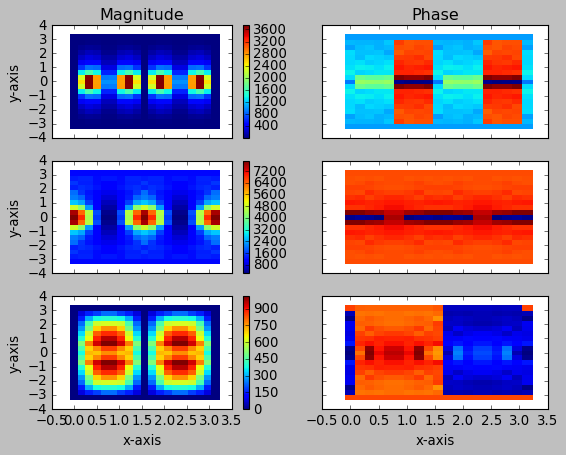

In [41]:
displayField(sE_FF)

In [42]:
FF_3D = np.sqrt(np.power(abs(sE_FF.DX),2) + np.power(abs(sE_FF.DY),2) + np.power(abs(sE_FF.DZ),2))

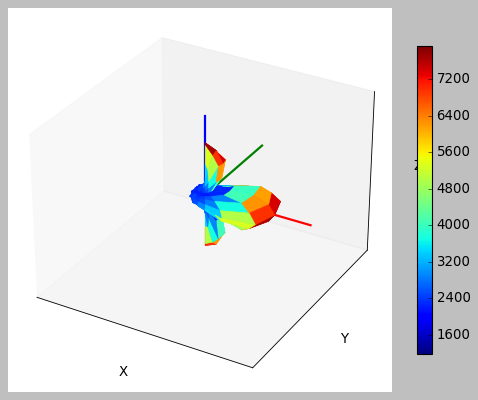

In [43]:
Pattern3D(Theta, Phi, FF_3D)

IndexError: index 45 is out of bounds for axis 1 with size 19

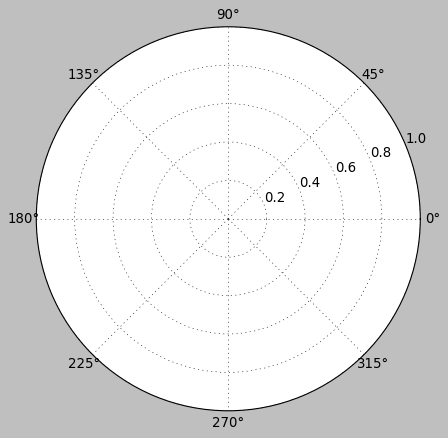

In [44]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi_[:], -60 + 10*np.log10(FF_3D[:,45]))
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Theta = 0°", va='bottom')
plt.show()